In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner
import keras
import tensorflow as tf

In [2]:
csv_file_path = './airbnb_dataset/data.csv'
df = pd.read_csv(csv_file_path)
pd.set_option('display.max_columns', None)
df.head()
save_path = './graphs/'

In [3]:
features = [col for col in df.columns if col != 'log_price']
features.remove('name_sentiment_analysis')
X = df[features]
y = df['log_price']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [4]:
def plot_metrics(history, test_loss, modelName = 'Model' ,ax = None, save = False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot training & validation loss values
    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    
    # Get the epoch where validation loss is minimum (best epoch)
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = np.min(history.history['val_loss'])

    # Highlight the best epoch
    ax.scatter(best_epoch, best_val_loss, color='green', s=100, marker='o', label='Best Epoch')

    # Plot test loss
    ax.hlines(test_loss, 0, len(history.history['loss']) - 1, colors='red', linestyles='dashed', label='Test Loss')

    ax.set_title(f'{modelName} Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    if save:
      plt.savefig(f'graphs/{modelName}.png')

### Train with NN

In [5]:
# Uncomment below if tensorflow is not installed already
#%pip install tensorflow
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout

In [6]:
# Build Neural Network
nn_model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# Train the model
history_nn = nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),verbose=0)

In [8]:
# Evaluate the model
mse_nn = nn_model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {mse_nn}")

463/463 [==============================] - 0s 413us/step - loss: 0.2021
Mean Squared Error on Test Set: 0.20212137699127197


In [10]:
import seaborn as sns
  
# Plot the residuals
def plot_residuals(df_plot, save = False):
  plt.figure(figsize=(5, 4))
  
  # Plot the residuals
  sns.scatterplot(x='Predicted', y='Residuals', data=df_plot, alpha=0.5)
  
  plt.title('Sampled Residuals vs. Predicted Values')
  plt.xlabel('Predicted Values')
  plt.ylabel('Sampled Residuals')
  
  # Add a horizontal line at y = 0
  plt.axhline(y=0, color='red', linestyle='--') 
  
  
  if save:
    plt.savefig(f'{save_path}residuals.png')
    
    
  plt.show()
  
  
def plot_regression(df_plot, degree,save = False):
  # Plot the truth vs prediction
  sns.regplot(data=df_plot, x='ground truth', y='ground truth', order = degree, ci = None, line_kws=dict(color="orange"), label ='Perfect Fit', scatter_kws={'alpha':0.5}, scatter=False)
  # Plot the polynomial fit
  sns.regplot(data=df_plot, x='ground truth', y='Predicted', order = degree, ci = 99, color='blue', line_kws=dict(color="r",label='Predictions'), scatter_kws={'alpha':0.5})
  
  plt.legend()
  
  if save:
    plt.savefig(f'{save_path}regression.png')



# Plot the graphs
def plot_graphs(y_test, yhat_test, degree = 1,save = False):
  df_plot = pd.DataFrame({'ground truth':y_test, 'Predicted': yhat_test, 'Residuals': y_test-yhat_test})
  df_plot = df_plot[np.abs(df_plot['Residuals']) < 0.9 * np.max(np.abs(df_plot['Residuals']))]
  df_sample = df_plot.sample(frac=0.1,random_state=42)
  plot_residuals(df_sample, save =save)
  plot_regression(df_sample, degree, save =save)

463/463 [==============================] - 0s 397us/step


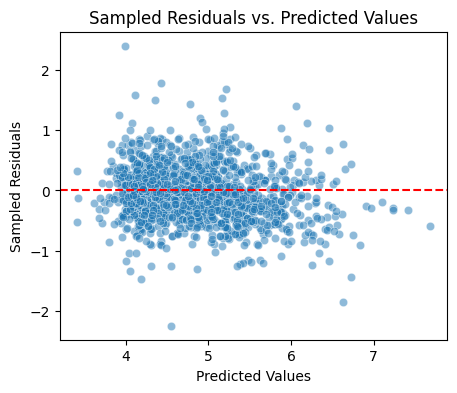

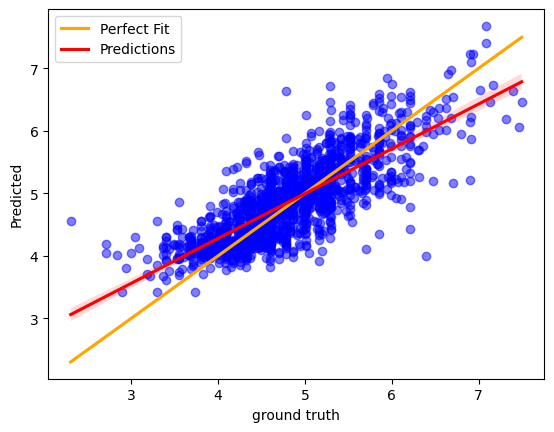

In [11]:
y_pred = nn_model.predict(X_test)
plot_graphs(y_test.squeeze(), y_pred.squeeze(), degree = 1, save = False)

### Hyper Tuning

In [12]:
def build_hp_model(hp):
    model = Sequential()
    # Iterate over the number of layers
    for i in range(hp.Int('num_layers', 2, 6)):
        # Define the number of units in the layer
        # And choose the activation function from a list of choices
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=96, step=16),
                        activation=hp.Choice('activation_' + str(i), ['leaky_relu'])))
    
    model.add(Dense(1))  # Output layer for regression
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    mode='min',
    restore_best_weights=True,
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='checkpoints',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only= False,
    mode='min'
)

In [14]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_hp_model,
    objective='val_loss',
    max_trials=8,
    seed=10,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='keras_tuner_demo',
    overwrite=True
)

In [15]:
# Start searching
tuner_search = tuner.search(X_train, y_train, epochs=20, callbacks=[early_stopping, model_checkpoint], validation_data=(X_val, y_val))

Trial 8 Complete [00h 01m 55s]
val_loss: 0.19147868951161703

Best val_loss So Far: 0.18858325481414795
Total elapsed time: 00h 09m 52s


In [16]:
# View best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found were: ", best_hyperparameters.values)

Best hyperparameters found were:  {'num_layers': 3, 'units_0': 64, 'activation_0': 'leaky_relu', 'units_1': 80, 'activation_1': 'leaky_relu', 'learning_rate': 0.0002137464742000241, 'units_2': 96, 'activation_2': 'leaky_relu', 'units_3': 80, 'activation_3': 'leaky_relu'}


In [17]:
best_model = tuner.get_best_models(num_models=1)[0]
mse_best = best_model.evaluate(X_test, y_test)[0]
print(f"Mean Squared Error on Test Set: {mse_best}")

463/463 [==============================] - 0s 481us/step - loss: 0.1907 - mean_squared_error: 0.1907
Mean Squared Error on Test Set: 0.19074809551239014


463/463 [==============================] - 0s 437us/step


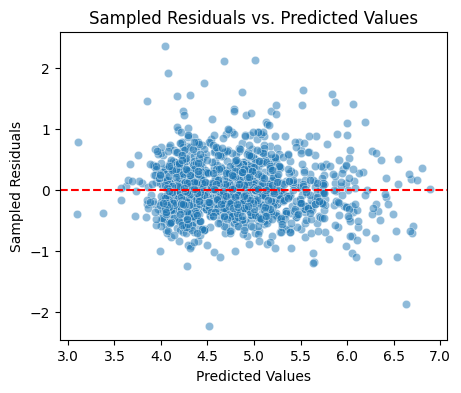

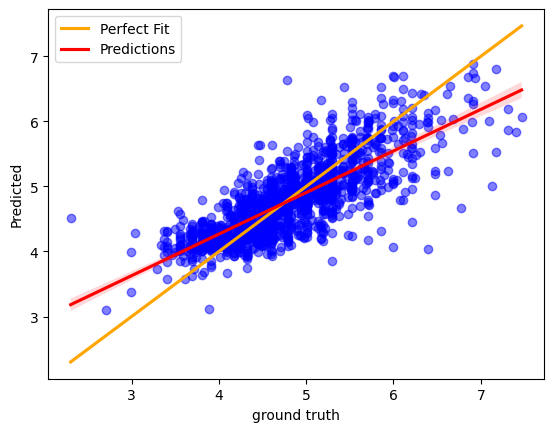

In [18]:
# After model evaluation
history_best = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),verbose=0)
test_loss_best = best_model.evaluate(X_test, y_test)[0]
y_pred = best_model.predict(X_test)

plot_graphs(y_test.squeeze(), y_pred.squeeze(), degree = 1, save = False)
# plot_metrics(history_best, test_loss_best, modelName = 'Best Model', save = True)

### Compare Different Models

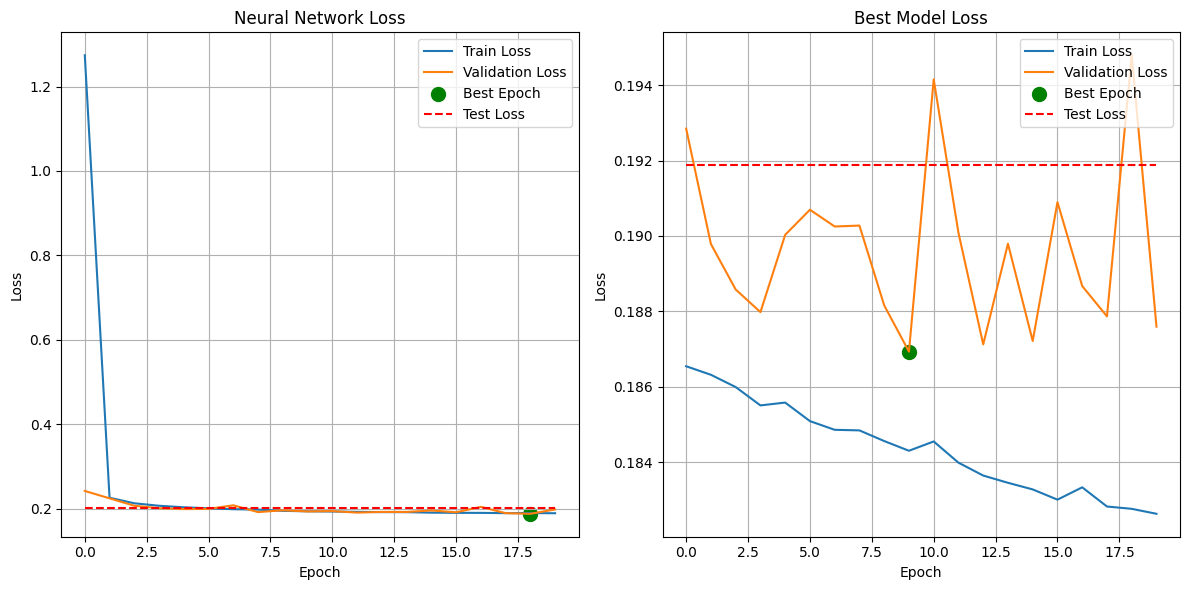

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_metrics(history_nn, mse_nn, modelName='Neural Network', ax = axs[0])
plot_metrics(history_best, test_loss_best, modelName = 'Best Model', ax = axs[1])
plt.tight_layout()
plt.show()